# Machine Learning at Scale, Part I

## KMeans clustering at scale

Training models with data that fits in memory is very limiting. But minibatch learners can easily work with data directly from disk. 

We'll use the MNIST data set, which has 8 million images (about 17 GB). The dataset has been partition into groups of 100k images (using the unix split command) and saved in compressed lz4 files. This dataset is very large and doesnt get loaded by default by <code>getdata.sh</code>. You have to load it explicitly by calling <code>getmnist.sh</code> from the scripts directory. The script automatically splits the data into files that are small enough to be loaded into memory. 

Let's load BIDMat/BIDMach

In [1]:
import BIDMat.{CMat,CSMat,DMat,Dict,IDict,Image,FMat,FND,GDMat,GMat,GIMat,GSDMat,GSMat,HMat,IMat,Mat,SMat,SBMat,SDMat}
import BIDMat.MatFunctions._
import BIDMat.SciFunctions._
import BIDMat.Solvers._
import BIDMat.JPlotting._
import BIDMach.Learner
import BIDMach.models.{FM,GLM,KMeans,KMeansw,ICA,LDA,LDAgibbs,Model,NMF,RandomForest,SFA,SVD}
import BIDMach.datasources.{DataSource,MatSource,FileSource,SFileSource}
import BIDMach.mixins.{CosineSim,Perplexity,Top,L1Regularizer,L2Regularizer}
import BIDMach.updaters.{ADAGrad,Batch,BatchNorm,IncMult,IncNorm,Telescoping}
import BIDMach.causal.{IPTW}

Mat.checkMKL
Mat.checkCUDA
Mat.setInline
if (Mat.hasCUDA > 0) GPUmem

1 CUDA device found, CUDA version 7.0


(0.99132067,11974557696,12079398912)

And define the root directory for this dataset.

In [2]:
val mdir = "../data/MNIST8M/parts/"

../data/MNIST8M/parts/

### Constrained Clustering. 

For this tutorial, we are going to evaluate the quality of clustering by using it for classification. We use a labeled dataset, and compute clusters of training samples using k-Means. Then we match new test samples to the clusters and find the best match. The label assigned to the new sample is the majority vote of the cluster. 

This method by itself doesnt work well. Clusters will often straddle label boundaries leading to poor labelings. Its better to force each cluster to have a single label. We do that by adding the labels in as very strong features before clustering. The label features cause samples with different labels to be very far apart. Far enough that k-Means will never assign them to the same cluster. The data we want looks like this:

<pre>
           Instance 0      Instance 1      Instance 2    ...
           has label "2"   has label "7"   has label "0" ...
           /    0               0           10000         ...
          |     0               0               0         ...
          | 10000               0               0         ...
          |     0               0               0         ...
label    /      0               0               0         ...
features \      0               0               0         ...
(10)      |     0               0               0         ...
          |     0           10000               0         ...
          |     0               0               0         ...
           \    0               0               0         ...

           /  128              19               5         ...
          |    47              28               9         ...
image    /     42             111              18         ...
features \     37             128              17         ...
(784)     |    18             176              14         ...
          |    ..              ..              ..

</pre>


We chose the label feature weights (here 10000) to force the distance between differently-labeled samples (2 * 10000^2) to be larger than the distance between two image samples (1000 * 256^2). This guarantees that points will not be assigned to a cluster containing a different label (assuming there is initially at least one cluster center with each label).  

Even though these label features are present in cluster centroids after training, they dont affect matching at test time. Test images dont have the label features, and will match the closest cluster based only on image features. That cluster will have a unique label, which we then assign to the test point. 

The files containind data in this form are named "alls00.fmat.lz4", "alls01.fmat.lz4" etc. Since they contain both data and labels, we dont need to load label files separately. We can create a learner using a pattern for accessing these files:

In [3]:
val (mm, opts) = KMeans.learner(mdir+"alls%02d.fmat.lz4")

BIDMach.models.KMeans$FileOptions@21efd653

The string "%02d" is a C/Scala format string that expands into a two-digit ASCII number to help with the enumeration.

There are several new options that can tailor a files datasource, but we'll mostly use the defaults. One thing we will do is define the last file to use for training (number 70). This leaves us with some held-out files to use for testing. 

In [4]:
opts.dim = 30000
opts.nend = 10

10

Note that the training data include image data and labels (0-9). K-Means is an unsupervised algorithm and if we used image data only KMeans will often build clusters containing different digit images. To produce cleaner clusters, and to facilitate classification later on, the <code>alls</code> data includes both labels in the first 10 rows, and image data in the remaining rows. The label features are scaled by a large constant factor. That means that images of different digits will be far apart in feature space. It effectively prevents different digits occuring in the same cluster. 

## Tuning Options

The following options are the important ones for tuning. For KMeans, batchSize has no effect on accracy since the algorithm uses all the data instances to perform an update. So you're free to tune it for best speed. Generally larger is better, as long as you dont use too much GPU ram. 

npasses is the number of passes over the dataset. Larger is typically better, but the model may overfit at some point. 

In [5]:
opts.batchSize = 20000
opts.npasses = 10

10

You invoke the learner the same way as before. You can change the options above after each run to optimize performance. 

In [6]:
mm.train

pass= 0
First pass random centroid initialization
 4.00%, ll=0.00000, gf=702.986, secs=1.4, GB=0.13, MB/s=93.55, GPUmem=0.347705
25.00%, ll=0.00000, gf=755.267, secs=2.5, GB=0.83, MB/s=326.65, GPUmem=0.334922
48.00%, ll=0.00000, gf=777.832, secs=3.7, GB=1.52, MB/s=414.04, GPUmem=0.330495
70.00%, ll=0.00000, gf=794.722, secs=4.8, GB=2.22, MB/s=462.68, GPUmem=0.327652
91.00%, ll=0.00000, gf=809.445, secs=5.9, GB=2.92, MB/s=495.49, GPUmem=0.325633
100.00%, ll=0.00000, gf=878.386, secs=6.5, GB=3.18, MB/s=487.04, GPUmem=0.325123
pass= 1
 4.00%, ll=-1447031.50000, gf=999.597, secs=8.6, GB=3.30, MB/s=384.25, GPUmem=0.118532
25.00%, ll=-1487285.37500, gf=1403.871, secs=20.4, GB=4.00, MB/s=196.12, GPUmem=0.118532
48.00%, ll=-1519196.25000, gf=1511.701, secs=32.2, GB=4.70, MB/s=145.91, GPUmem=0.118532
70.00%, ll=-1528522.62500, gf=1561.714, secs=44.0, GB=5.40, MB/s=122.64, GPUmem=0.118532
91.00%, ll=-1480058.12500, gf=1590.571, secs=55.8, GB=6.10, MB/s=109.22, GPUmem=0.118532
100.00%, ll=-146480

Now lets extract the model as a Floating-point matrix. We included the category features for clustering to make sure that each cluster is a subset of images for one digit. 

In [7]:
val modelmat = FMat(mm.modelmat)

      0      0      0      0      0      0      0      0      0  10000...
  10000      0      0      0      0      0      0      0      0      0...
  10000      0      0      0      0      0      0      0      0      0...
      0      0      0      0      0      0  10000      0      0      0...
      0  10000      0      0      0      0      0      0      0      0...
      0      0      0  10000      0      0      0      0      0      0...
  10000      0      0      0      0      0      0      0      0      0...
      0  10000      0      0      0      0      0      0      0      0...
     ..     ..     ..     ..     ..     ..     ..     ..     ..     ..


Next we build a 30 x 10 array of images to view the first 300 cluster centers as images.

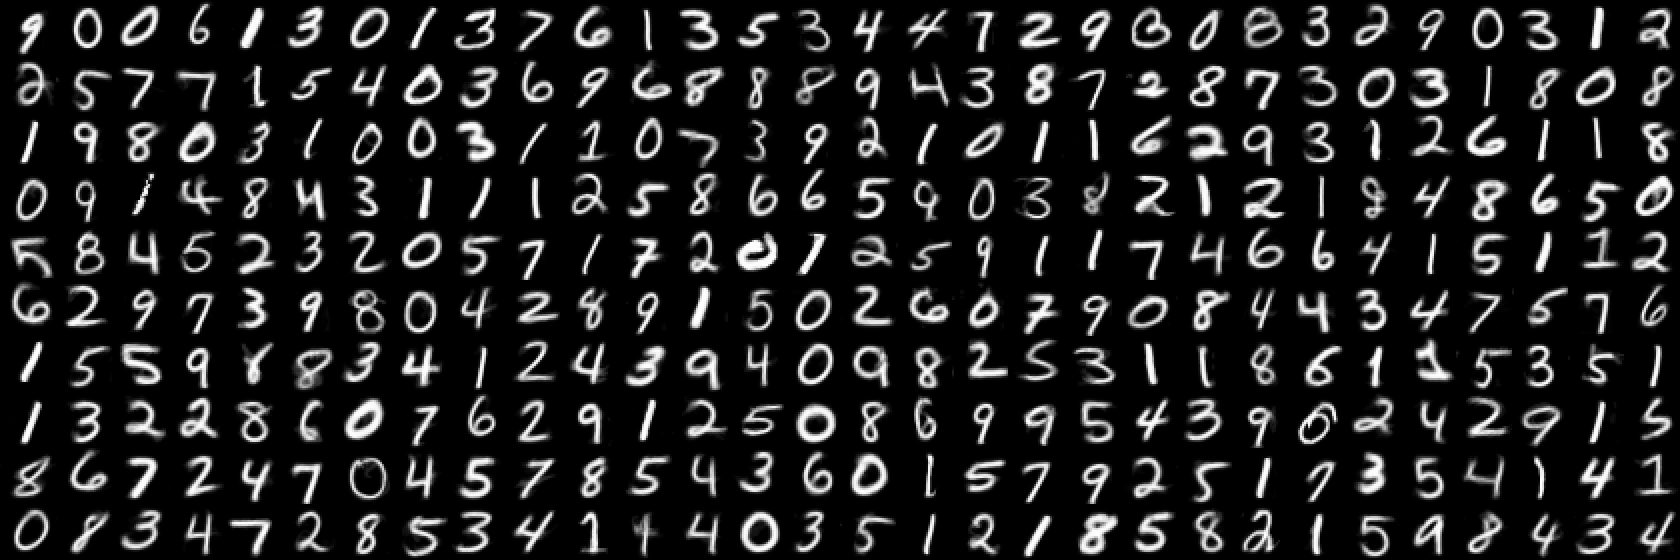

In [8]:
val nx = 30
val ny = 10
val im = zeros(28,28)
val allim = zeros(28*nx,28*ny)
for (i<-0 until nx) {
    for (j<-0 until ny) {
        val slice = modelmat(i+nx*j,10->794)
        im(?) = slice(?)
        allim((28*i)->(28*(i+1)), (28*j)->(28*(j+1))) = im
    }
}
show(allim kron ones(2,2))

We'll predict using the closest cluster (or 1-NN if you like). Since we did constrained clustering, our data include the labels for each instance, but unlabeled test data doesnt have this. So we project the model matrix down to remove its first 10 features. Before doing this though we find the strongest label for each cluster so later on we can map from cluster id to label. 

In [9]:
val igood = find(sum(modelmat,2) > 100)                // find non-empty clusters
val mmat = modelmat(igood,?)

      0      0      0      0      0      0      0      0      0  10000...
  10000      0      0      0      0      0      0      0      0      0...
  10000      0      0      0      0      0      0      0      0      0...
      0      0      0      0      0      0  10000      0      0      0...
      0  10000      0      0      0      0      0      0      0      0...
      0      0      0  10000      0      0      0      0      0      0...
  10000      0      0      0      0      0      0      0      0      0...
      0  10000      0      0      0      0      0      0      0      0...
     ..     ..     ..     ..     ..     ..     ..     ..     ..     ..


In [10]:

val (dmy, catmap) = maxi2(mmat(?,0->10).t)                // Lookup the label for each cluster
mm.model.modelmats(0) = mmat(?,10->mmat.ncols)            // Remove the label features
mm.model.modelmats(1) = mm.modelmats(1)(igood,0)
catmap(0->100)

9,0,0,6,1,3,0,1,3,7,6,1,3,5,3,4,4,7,2,9,3,0,8,3,2,9,0,3,1,2,2,5,7,7,1,5,4,0,3,6,9,6,8,8,8,9,4,3,8,7,2,8,7,3,0,3,1,8,0,8,1,9,8,0,3,1,0,0,3,1,1,0,7,3,9,2,1,0,1,1,6,2,9,3,1,2,6,1,1,8,0,9,1,4,8,4,3,1,1,1

Next we define a predictor from the just-computed model and the testdata, with the preds files to catch the predictions.

In [18]:
val (pp, popts) = KMeans.predictor(mm.model, mdir+"data%02d.fmat.lz4", mdir+"preds%02d.imat.lz4")

popts.nstart = 70                                      // start with file 70 as test data
popts.nend = 80                                        // finish at file 79
popts.ofcols = 100000                                  // Match number of samples per file to test file
popts.batchSize = 10000

10000

Lets run the predictor

In [19]:
pp.predict 

Predicting
 2.00%, ll=-101005864.00000, gf=813.954, secs=1.1, GB=0.06, MB/s=55.07, GPUmem=0.67
 3.00%, ll=-100983656.00000, gf=979.324, secs=1.4, GB=0.09, MB/s=66.25, GPUmem=0.67
 5.00%, ll=-101019392.00000, gf=1188.581, secs=2.0, GB=0.16, MB/s=80.41, GPUmem=0.67
 6.00%, ll=-100990560.00000, gf=1246.652, secs=2.2, GB=0.19, MB/s=84.34, GPUmem=0.67
 8.00%, ll=-101043492.00000, gf=1335.388, secs=2.8, GB=0.25, MB/s=90.34, GPUmem=0.67
10.00%, ll=-100993888.00000, gf=1388.280, secs=3.3, GB=0.31, MB/s=93.92, GPUmem=0.67
11.00%, ll=-101004648.00000, gf=1414.821, secs=3.6, GB=0.34, MB/s=95.72, GPUmem=0.67
12.00%, ll=-101008464.00000, gf=1431.804, secs=3.9, GB=0.38, MB/s=96.86, GPUmem=0.67
14.00%, ll=-101006396.00000, gf=1464.602, secs=4.4, GB=0.44, MB/s=99.08, GPUmem=0.67
16.00%, ll=-100992752.00000, gf=1490.204, secs=5.0, GB=0.50, MB/s=100.82, GPUmem=0.67
17.00%, ll=-101068400.00000, gf=1510.744, secs=5.5, GB=0.56, MB/s=102.21, GPUmem=0.67
19.00%, ll=-100991520.00000, gf=1521.663, secs=5.8, GB

The <code>preds</code> files now contains the numbers of the best-matching cluster centers. We still need to look up the category label for each one, and compare with the reference data. We'll do this one file at a time, so that our evaluation can scale to arbitrary problem sizes. 

In [20]:
val totals = (popts.nstart until popts.nend).map(i => {
                    val preds = loadIMat(mdir + "preds%02d.imat.lz4" format i);    // predicted centroids
                    val cats = loadIMat(mdir + "cat%02d.imat.lz4" format i);       // reference labels
                    val cpreds = catmap(preds);                                    // map centroid to label
                    accum(cats.t \ cpreds.t, 1.0, 10, 10)                          // form a confusion matrix
}).reduce(_+_)

totals

   98512      24      17      15       3      32     104      14      24...
       0  112177      28       8      20       0      12      52       3...
     148     174   98284      59      10      16      33     408      87...
      15      45     149  100926       1     456       7     164     300...
      17     240       5       0   95776       3      78     104      12...
      53      21      18     344      15   89357     344       9      86...
     140      62      14       3      43     169   98130       0      41...
       0     441      98       5     130       2       0  103225       9...
      ..      ..      ..      ..      ..      ..      ..      ..      ..


From the actual and predicted categories, we can compute a confusion matrix:

In [21]:
val conf = float(totals / sum(totals))

     0.99453  0.00021154  0.00017225  0.00014721  3.1033e-05  0.00035376...
           0     0.98874  0.00028370  7.8512e-05  0.00020689           0...
   0.0014941   0.0015337     0.99584  0.00057903  0.00010344  0.00017688...
  0.00015143  0.00039664   0.0015097     0.99049  1.0344e-05   0.0050410...
  0.00017162   0.0021154  5.0661e-05           0     0.99073  3.3165e-05...
  0.00053506  0.00018510  0.00018238   0.0033760  0.00015516     0.98783...
   0.0014134  0.00054648  0.00014185  2.9442e-05  0.00044480   0.0018683...
           0   0.0038870  0.00099296  4.9070e-05   0.0013448  2.2110e-05...
          ..          ..          ..          ..          ..          ..


Now lets create an image by multiplying each confusion matrix cell by a white square:

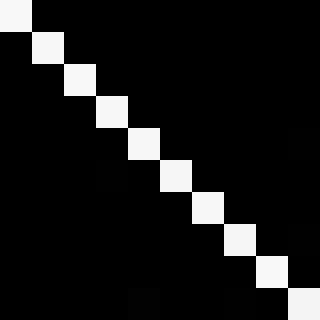

In [22]:
show((conf * 250f) ⊗ ones(32,32))

Its useful to isolate the correct classification rate by digit, which is:

In [23]:
val dacc = getdiag(conf).t

0.99453,0.98874,0.99584,0.99049,0.99073,0.98783,0.99188,0.98695,0.99332,0.97656

We can take the mean of the diagonal accuracies to get an overall accuracy for this model. 

In [24]:
mean(dacc)

0.98969

Run the experiment again with a larger number of clusters (3000, then 30000). You should reduce the batchSize option to 20000 to avoid memory problems.

Include the training time output by the call to <code>nn.train</code> but not the evaluation time. Rerun and fill out the table below: 

<table>
<tr>
<th>KMeans Clusters</th>
<th>Training time</th>
<th>Avg. gflops</th>
<th>Accuracy</th>
</tr>
<tr>
<td>300</td>
<td>...</td>
<td>...</td>
<td>...</td>
</tr>
<tr>
<td>3000</td>
<td>...</td>
<td>...</td>
<td>...</td>
</tr>
<tr>
<td>30000</td>
<td>...</td>
<td>...</td>
<td>...</td>
</tr>
</table>